## Initial Data Preprocessing and EDA

1. Converting all Images into pixels to be processed by a computer vision model
2. Initial EDA (class balances)
3. Creating a column which combines the skin complexion and skin disease columns in order to conduct a stratified random sample from both columns

In [ ]:
import pandas as pd
import numpy as np
import os
from PIL import Image

In [ ]:
### This file contains all the labels (manually annotated) for individuals' skin complexion within the dataset
label_path = "/content/drive/MyDrive/Colab Notebooks/labels.csv"
labelled_race_imgs = pd.read_csv(label_path)

In [ ]:
labelled_race_imgs.iloc[334, 1] = "dark"

In [ ]:
labelled_race_imgs["label"].value_counts()

label
light    659
dark      56
Name: count, dtype: int64

In [ ]:
### Iterating through the images and converting to pixels
image_database_path = "/content/drive/MyDrive/imagedatabase/"

image_data = []

for img_path in os.listdir(image_database_path):
    full_path = os.path.join(image_database_path, img_path)
    if img_path.startswith(".") or not os.path.isfile(full_path):
        continue
    try:
        with Image.open(full_path) as img:
            pixeled_img = np.array(img.convert("RGB")) / 255.0

        skin_type = img_path.split("_")[0]

        image_data.append({"img_path": img_path, "pixels": pixeled_img, "label": skin_type})
    except Exception as e:
        print(f"Failed to process {img_path}: {e}")

acne_df = pd.DataFrame(image_data)

print(acne_df.head())

                img_path                                             pixels  \
0  acne_7_right_side.jpg  [[[0.24705882352941178, 0.592156862745098, 0.7...   
1       acne_6_front.jpg  [[[0.611764705882353, 0.6196078431372549, 0.66...   
2   acne_9_left_side.jpg  [[[0.8, 0.7529411764705882, 0.6588235294117647...   
3   acne_7_left_side.jpg  [[[0.1803921568627451, 0.5176470588235295, 0.7...   
4  acne_6_right_side.jpg  [[[0.34901960784313724, 0.35294117647058826, 0...   

  label  
0  acne  
1  acne  
2  acne  
3  acne  
4  acne  


In [ ]:
### Merging images and labels into one dataframe
result_outer = pd.merge(acne_df, labelled_race_imgs, left_on = "img_path", right_on = "image_name", how = "outer")
result_outer = result_outer.drop(columns = ["img_path", "image_name"])

In [ ]:
result_outer = result_outer.rename(columns = {"label_x": "acne_label", "label_y": "skin_complexion_label"})
result_outer.head()

,pixels,acne_label,skin_complexion_label
0,"[[[0.24705882352941178, 0.592156862745098, 0.7...",acne,light
1,"[[[0.611764705882353, 0.6196078431372549, 0.66...",acne,dark
2,"[[[0.8, 0.7529411764705882, 0.6588235294117647...",acne,dark
3,"[[[0.1803921568627451, 0.5176470588235295, 0.7...",acne,dark
4,"[[[0.34901960784313724, 0.35294117647058826, 0...",acne,dark


In [ ]:
acne_df = result_outer.copy()

In [ ]:
### Total amount of labels per class of skin disease
acne_df["acne_label"].value_counts()

acne_label
acne                    155
actinic keratosis       125
rosacea                 125
basal cell carcinoma    125
eczemaa                 125
bags                     30
redness                  30
Name: count, dtype: int64

In [ ]:
acne_df.groupby(["skin_complexion_label", "acne_label"]).count()

pixels
skin_complexion_label acne_label                  
dark                  acne                      21
                      actinic keratosis          1
                      bags                      19
                      basal cell carcinoma       1
                      eczemaa                    3
                      redness                    9
                      rosacea                    2
light                 acne                     134
                      actinic keratosis        124
                      bags                      11
                      basal cell carcinoma     124
                      eczemaa                  122
                      redness                   21
                      rosacea                  123

In [ ]:
np.stack(acne_df["pixels"]).shape

(715, 256, 256, 3)

In [ ]:
### Creating a column to use when performing a stratified random sample
acne_df['strata'] = acne_df.apply(lambda row: f"{row['acne_label']}_{row['skin_complexion_label']}", axis=1)
acne_df = acne_df[(acne_df["strata"] != "actinic keratosis_dark") & (acne_df["strata"] != "basal cell carcinoma_dark")]

In [ ]:
acne_df["strata"].value_counts()

strata
acne_light                    134
actinic keratosis_light       124
basal cell carcinoma_light    124
rosacea_light                 123
eczemaa_light                 122
acne_dark                      21
redness_light                  21
bags_dark                      19
bags_light                     11
redness_dark                    9
eczemaa_dark                    3
rosacea_dark                    2
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X = acne_df[["pixels", "skin_complexion_label"]]
y = acne_df["acne_label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=acne_df["strata"], random_state=0)

In [ ]:
X_train_pixels = np.stack(X_train["pixels"])
X_test_pixels = np.stack(X_test["pixels"])

In [ ]:
disease_names = y_train.unique()
y_train_encoded = pd.get_dummies(y_train).to_numpy()

## Baseline Convolutional Neural Network Model

1.   Building a CNN from scratch for predicting skin diseases
2.   Evaluating the intial performance of the CNN on both classes of skin complexion
3. Introducing a weight sampling adjustment to increase the effect of misclassifications on the minority class to induce error parity in the model and evaluating results





In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

In [ ]:
keras.utils.set_random_seed(42)

In [ ]:
input = keras.Input(shape=(256, 256, 3), name="input")

### Data Augmentation to reduce overfitting
h = keras.layers.RandomFlip("horizontal")(input)
h = keras.layers.RandomZoom(0.2)(h)

# First convolutional layer
h = keras.layers.Rescaling(1./255, name = "rescaling_1")(input)
h = keras.layers.Conv2D(16, kernel_size=(2, 2), activation="relu", name="Conv_1")(h)
# First pooling layer
h = keras.layers.MaxPool2D()(h)
h = keras.layers.Dropout(0.2)(h)

# Second convolutional layer + dropout layer
h = keras.layers.Conv2D(16, kernel_size = (2, 2), activation = "relu", name = "Conv_2")(h)
h = keras.layers.MaxPool2D()(h)
h = keras.layers.Dropout(0.2)(h)

# Third convolutional layer
h = keras.layers.Conv2D(16, kernel_size = (2, 2), activation = "relu", name = "Conv_3")(h)
h = keras.layers.MaxPool2D()(h)


## Flatten + output layer
h = keras.layers.Flatten()(h)
h = keras.layers.Dense(256, activation='relu')(h)

output = keras.layers.Dense(7, activation="softmax")(h)


model = keras.Model(input, output, name='CNN_model')
model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 Conv_1 (Conv2D)             (None, 255, 255, 16)      208       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 127, 127, 16)      0         
                                                                 
 Conv_2 (Conv2D)             (None, 126, 126, 16)      1040      
                                                         

In [ ]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

model_history = model.fit(
    X_train_pixels, y_train_encoded,
    epochs = 30, batch_size = 15,
    validation_split = 0.20
)

Epoch 1/30
31/31 [==============================] - 3s 41ms/step - loss: 1.8552 - accuracy: 0.1996 - val_loss: 1.8204 - val_accuracy: 0.1491
Epoch 2/30
31/31 [==============================] - 1s 24ms/step - loss: 1.8330 - accuracy: 0.1798 - val_loss: 1.8221 - val_accuracy: 0.2281
Epoch 3/30
31/31 [==============================] - 1s 27ms/step - loss: 1.8335 - accuracy: 0.2149 - val_loss: 1.8291 - val_accuracy: 0.2281
Epoch 4/30
31/31 [==============================] - 1s 28ms/step - loss: 1.8455 - accuracy: 0.2149 - val_loss: 1.8298 - val_accuracy: 0.2281
Epoch 5/30
31/31 [==============================] - 1s 30ms/step - loss: 1.8298 - accuracy: 0.1842 - val_loss: 1.8201 - val_accuracy: 0.2281
Epoch 6/30
31/31 [==============================] - 1s 29ms/step - loss: 1.8292 - accuracy: 0.2127 - val_loss: 1.8259 - val_accuracy: 0.2281
Epoch 7/30
31/31 [==============================] - 1s 24ms/step - loss: 1.8478 - accuracy: 0.1974 - val_loss: 1.8614 - val_accuracy: 0.1491
Epoch 8/30
31

In [ ]:
accuracy = model.evaluate(X_test_pixels, pd.get_dummies(y_test).to_numpy())
print("Model Accuracy:", accuracy[1])

5/5 [==============================] - 0s 18ms/step - loss: 1.8168 - accuracy: 0.2168
Model Accuracy: 0.21678321063518524


In [ ]:
accuracy = model.evaluate(X_train_pixels, y_train_encoded)
print("Model Accuracy:", accuracy[1])

18/18 [==============================] - 0s 18ms/step - loss: 1.8163 - accuracy: 0.2175
Model Accuracy: 0.2175438553094864


In [ ]:
y_test_encoded = pd.get_dummies(y_test).to_numpy()

5/5 [==============================] - 0s 14ms/step
*************************
* Test Accuracy: 0.3427 *
*************************


,acne,actinic keratosis,bags,basal cell carcinoma,eczemaa,redness,rosacea
acne,3,11,1,5,8,1,2
actinic keratosis,1,14,1,7,1,0,1
bags,0,1,2,2,1,0,0
basal cell carcinoma,3,8,0,14,0,0,0
eczemaa,2,5,0,10,6,1,1
redness,0,1,0,0,0,5,0
rosacea,2,12,0,3,3,0,5


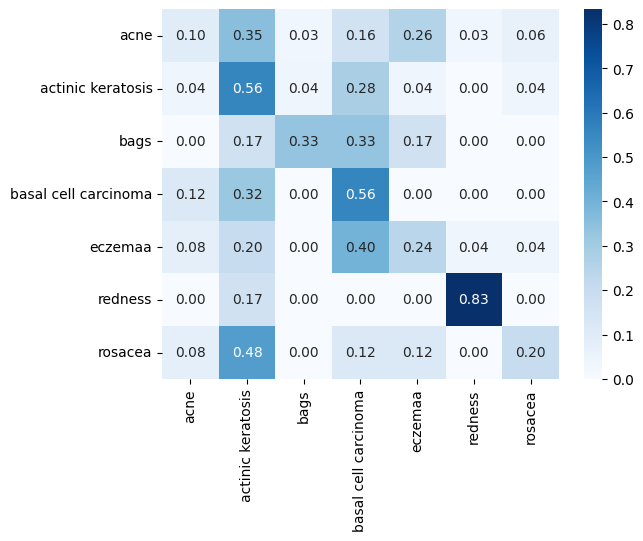

In [ ]:
from IPython.display import display

def show_confusion_matrix(model):
    global y_test, X_test

    disease_names = pd.get_dummies(y_test).columns

    y_pred = model.predict(X_test_pixels).argmax(axis=1)
    y_actual = y_test_encoded.argmax(axis=1)

    print('*************************\n* Test Accuracy: %.4f *\n*************************' % metrics.accuracy_score(y_actual, y_pred))

    cm = pd.DataFrame(metrics.confusion_matrix(y_actual, y_pred), index=disease_names, columns=disease_names)
    display(cm)

    cm = cm.div(cm.sum(axis=1), axis=0)

    sns.heatmap(cm, cmap="Blues", annot=True, fmt=".2f")

show_confusion_matrix(model)

In [ ]:
predictions = model.predict(X_test_pixels)
class_predictions = predictions.argmax(axis = 1)

5/5 [==============================] - 0s 14ms/step


In [ ]:
### Compute accuracies per skin complexion type (light vs dark)
results_df = pd.DataFrame({
    'actual': pd.get_dummies(y_test).to_numpy().argmax(axis = 1),
    'predicted': class_predictions,
    'sensitive_attribute': X_test["skin_complexion_label"]
})

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

group_metrics = {}

for group in results_df['sensitive_attribute'].unique():
    group_data = results_df[results_df['sensitive_attribute'] == group]
    accuracy = accuracy_score(group_data['actual'], group_data['predicted'])
    group_metrics[group] = {'accuracy': accuracy}
    print(f"Metrics for group {group}:", group_metrics[group])

Metrics for group light: {'accuracy': 0.4772727272727273}
Metrics for group dark: {'accuracy': 0.45454545454545453}


#### Weight adjustment to improve performance on underrepresented class (darker skin complexion)

In [ ]:
weights = np.ones(len(y_train))

weight_factor = 1.5  # This factor could be tuned based on validation performance
weights[X_train["skin_complexion_label"] == 'dark'] = weight_factor
weights[X_train["skin_complexion_label"] == 'light'] = 1.25

In [ ]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"],
    weighted_metrics = ["accuracy"]
)

model_history = model.fit(
    X_train_pixels, y_train_encoded,
    epochs = 30, batch_size = 15,
    validation_split = 0.20, sample_weight=weights
)

Epoch 1/30
31/31 [==============================] - 3s 45ms/step - loss: 0.0185 - accuracy: 0.9934 - weighted_accuracy: 0.9935 - val_loss: 7.1967 - val_accuracy: 0.4123 - val_weighted_accuracy: 0.4093
Epoch 2/30
31/31 [==============================] - 1s 26ms/step - loss: 0.0809 - accuracy: 0.9825 - weighted_accuracy: 0.9827 - val_loss: 6.8088 - val_accuracy: 0.4211 - val_weighted_accuracy: 0.4180
Epoch 3/30
31/31 [==============================] - 1s 25ms/step - loss: 0.0288 - accuracy: 0.9912 - weighted_accuracy: 0.9914 - val_loss: 6.7444 - val_accuracy: 0.4035 - val_weighted_accuracy: 0.4007
Epoch 4/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0151 - accuracy: 0.9956 - weighted_accuracy: 0.9957 - val_loss: 6.7593 - val_accuracy: 0.4035 - val_weighted_accuracy: 0.4007
Epoch 5/30
31/31 [==============================] - 1s 28ms/step - loss: 0.0045 - accuracy: 1.0000 - weighted_accuracy: 1.0000 - val_loss: 6.7504 - val_accuracy: 0.3684 - val_weighted_accuracy: 0.

In [ ]:
accuracy = model.evaluate(X_test_pixels, pd.get_dummies(y_test).to_numpy())
print("Model Accuracy:", accuracy[1])

5/5 [==============================] - 0s 16ms/step - loss: 5.4725 - accuracy: 0.4755 - weighted_accuracy: 0.4755
Model Accuracy: 0.4755244851112366


In [ ]:
accuracy = model.evaluate(X_train_pixels, pd.get_dummies(y_train).to_numpy())
print("Model Accuracy:", accuracy[1])

18/18 [==============================] - 0s 18ms/step - loss: 1.2145 - accuracy: 0.8772 - weighted_accuracy: 0.8772
Model Accuracy: 0.8771929740905762


In [ ]:
predictions_fair = model.predict(X_test_pixels)
class_predictions_fair = predictions_fair.argmax(axis = 1)

5/5 [==============================] - 0s 13ms/step


In [ ]:
results_df = pd.DataFrame({
    'actual': pd.get_dummies(y_test).to_numpy().argmax(axis = 1),
    'predicted': class_predictions_fair,
    'sensitive_attribute': X_test["skin_complexion_label"]
})

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

group_metrics = {}

for group in results_df['sensitive_attribute'].unique():
    group_data = results_df[results_df['sensitive_attribute'] == group]
    accuracy = accuracy_score(group_data['actual'], group_data['predicted'])
    group_metrics[group] = {
        'accuracy': accuracy,
    }
    print(f"Metrics for group {group}:", group_metrics[group])

Metrics for group light: {'accuracy': 0.4772727272727273}
Metrics for group dark: {'accuracy': 0.45454545454545453}


## ViT - Vision Transformer Model

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms

class AcneDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.weights = torch.ones(dataframe.shape[0])
        #self.weights[dataframe["skin_complexion_label"] == "dark"] = 1.5


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_data = self.dataframe.iloc[idx]['pixels']
        image = Image.fromarray((image_data * 255).astype('uint8'), 'RGB')

        image = self.transform(image)

        label = self.dataframe.iloc[idx]['label']
        label = torch.tensor(self._label_encoder(label), dtype=torch.long)

        weights = self.weights

        return image, label, weights

    def _label_encoder(self, label):
        label_mapping = {'acne': 0, 'redness': 1, 'actinic keratosis': 2, 'basal cell carcinoma': 3, 'rosacea': 4, 'eczemaa': 5, 'bags': 6}
        return label_mapping[label]

#acne_dataset = AcneDataset(acne_df)

In [ ]:
VIT_train = X_train.copy()
#VIT_train = VIT_train#.drop(columns = "skin_complexion_label")
VIT_train["label"] = y_train
VIT_train = VIT_train.reset_index(drop = True)

VIT_test = X_test.copy()
#VIT_test = VIT_test.drop(columns = "skin_complexion_label")
VIT_test["label"] = y_test
VIT_test = VIT_test.reset_index(drop = True)

In [ ]:
train_VIT = AcneDataset(VIT_train)
test_VIT = AcneDataset(VIT_test)

In [ ]:
train_loader = DataLoader(train_VIT, batch_size=15, shuffle=True)
validation_loader = DataLoader(test_VIT, batch_size=15, shuffle=False)

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

model.classifier = torch.nn.Linear(model.config.hidden_size, len(set(acne_df['acne_label'])))

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
def evaluate_accuracy(model, data_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, weights in data_loader:
            images, labels, weights = images.to(device), labels.to(device), weights.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
def train_model(model, train_loader, validation_loader, optimizer, loss_fn, epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels, weights in train_loader:
            images, labels, weights = images.to(device), labels.to(device), weights.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)
            weighted_losses = loss * weights
            final_loss = weighted_losses.mean()
            final_loss.backward()
            optimizer.step()
            total_loss += final_loss.item()

        print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(train_loader)}')

        validation_accuracy = evaluate_accuracy(model, validation_loader)
        print(f'Epoch {epoch+1}, Validation Accuracy: {validation_accuracy}%')

In [ ]:
train_model(model, train_loader, validation_loader, optimizer, loss_fn)

Epoch 1, Average Loss: 2.002693053923155
Epoch 1, Validation Accuracy: 24.475524475524477%
Epoch 2, Average Loss: 1.8228456566208286
Epoch 2, Validation Accuracy: 18.181818181818183%
Epoch 3, Average Loss: 1.800795737065767
Epoch 3, Validation Accuracy: 24.475524475524477%
Epoch 4, Average Loss: 1.720983558579495
Epoch 4, Validation Accuracy: 23.776223776223777%
Epoch 5, Average Loss: 1.7676722250486676
Epoch 5, Validation Accuracy: 22.377622377622377%
Epoch 6, Average Loss: 1.7890070519949262
Epoch 6, Validation Accuracy: 27.972027972027973%
Epoch 7, Average Loss: 1.708453263107099
Epoch 7, Validation Accuracy: 29.37062937062937%
Epoch 8, Average Loss: 1.6596706760557074
Epoch 8, Validation Accuracy: 20.97902097902098%
Epoch 9, Average Loss: 1.6475481767403453
Epoch 9, Validation Accuracy: 28.67132867132867%
Epoch 10, Average Loss: 1.6266890011335675
Epoch 10, Validation Accuracy: 27.272727272727273%
Epoch 11, Average Loss: 1.6386016230834157
Epoch 11, Validation Accuracy: 26.57342657

In [ ]:
evaluate_accuracy(model, validation_loader)

42.65734265734266

In [ ]:
VIT_test_l = X_test.copy()
VIT_test_l["label"] = y_test
VIT_test_dark = VIT_test_l[VIT_test_l["skin_complexion_label"] == "dark"].reset_index(drop = True)#.drop(columns = ["skin_complexion_label"])
VIT_test_light = VIT_test_l[VIT_test_l["skin_complexion_label"] == "light"].reset_index(drop = True)#.drop(columns = ["skin_complexion_label"])

In [ ]:
dark_vit = AcneDataset(VIT_test_dark)
light_vit = AcneDataset(VIT_test_light)

In [ ]:
dark_loader = DataLoader(dark_vit, batch_size=15, shuffle=True)
light_loader = DataLoader(light_vit, batch_size=15, shuffle=True)

In [ ]:
evaluate_accuracy(model, light_loader)

42.42424242424242

### Saliency Maps

In [ ]:
from PIL import Image
from torchvision import transforms

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = Image.open("/content/acne_1.jpg")  # Load your image file
print(image.size)
image = transform(image).unsqueeze(0)  # Add a batch dimension

(256, 256)


In [ ]:
# Ensure CUDA availability
saliency = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make the tensor a leaf node and move to the appropriate device
image = image.clone().detach().to(device)
image.requires_grad_()  # Set requires_grad to True after moving to device

# Model to device
model = model.to(device)

# Forward pass
outputs = model(image)

# Select the target class if not specified
_, target_class = outputs.logits.max(dim=1)

# Backward pass for the target class
model.zero_grad()
target = outputs.logits[0, target_class]
target.backward()

# Compute the saliency map
saliency, _ = torch.max(image.grad.data.abs(), dim=1)

In [ ]:
transformed_image = image.cpu().data.squeeze(0)  # Remove batch dim and move to cpu
transformed_image = transformed_image.numpy().transpose(1, 2, 0)  # Change from CxHxW to HxWxC
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transformed_image = std * transformed_image + mean  # Reverse normalization
transformed_image = np.clip(transformed_image, 0, 1)  # Ensure the values are between 0 and 1

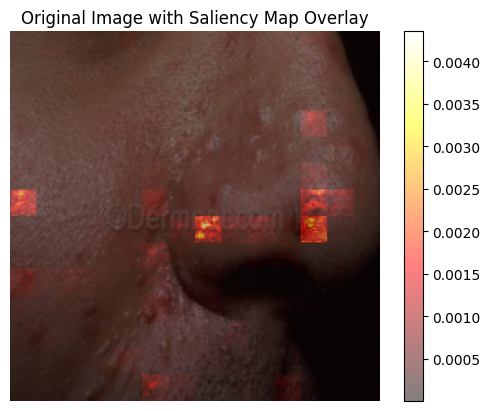

In [ ]:
import matplotlib.pyplot as plt

saliency = saliency.cpu().numpy()

# Plot the original image
plt.imshow(transformed_image)
plt.axis('off')  # Turn off axis numbers and ticks

# Overlay the saliency map
# 'saliency[0]' should already be in CPU memory and converted to a numpy array
plt.imshow(saliency[0], cmap='hot', alpha=0.5)  # 'alpha' controls the transparency of the overlay

plt.colorbar()  # Optionally add a color bar
plt.title('Original Image with Saliency Map Overlay')
plt.show()

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

def generate_and_plot_saliency(image_path, model):
    # Imageransformation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Preprocess  image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension

    # CUDA availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_tensor = image_tensor.to(device)
    image_tensor.requires_grad_()

    # Model
    model = model.to(device)
    model.eval()

    # Forward pass
    outputs = model(image_tensor)

    # Find target class
    _, target_class = outputs.logits.max(dim=1)

    # Backward pass for selected highest class
    model.zero_grad()
    target = outputs.logits[0, target_class]
    target.backward()

    # Compute the saliency map
    saliency, _ = torch.max(image_tensor.grad.data.abs(), dim=1)
    saliency = saliency.cpu().numpy()

    # Process the image for plotting
    transformed_image = image_tensor.cpu().data.squeeze(0)
    transformed_image = transformed_image.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    transformed_image = std * transformed_image + mean
    transformed_image = np.clip(transformed_image, 0, 1)

    # Plot
    plt.imshow(transformed_image)
    plt.axis('off')  # Turn off axis numbers and ticks

    # Overlay the saliency map
    # 'saliency[0]' should already be in CPU memory and converted to a numpy array
    plt.imshow(saliency[0], cmap='hot', alpha=0.5)  # 'alpha' controls the transparency of the overlay

    plt.colorbar()  # Optionally add a color bar
    plt.title('Lighter Complexion Acne Saliency Map')
    plt.show()

    return saliency

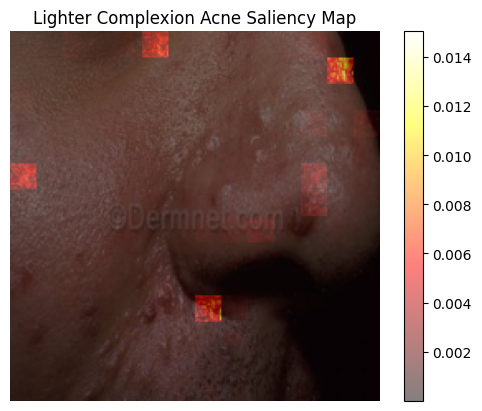

array([[[3.94749768e-05, 3.12225384e-05, 2.83329082e-05, ...,
         1.61342323e-04, 1.36086790e-04, 1.45005833e-04],
        [3.11648728e-05, 2.45733936e-05, 2.90940461e-05, ...,
         1.30363580e-04, 1.10478846e-04, 9.92700006e-05],
        [1.72708424e-05, 2.05884207e-05, 1.96979381e-05, ...,
         9.28199588e-05, 9.29842208e-05, 1.05377228e-04],
        ...,
        [1.32757423e-05, 3.42076601e-05, 3.98943812e-05, ...,
         8.52841331e-05, 9.00319574e-05, 1.12893526e-04],
        [1.73340031e-05, 3.19698738e-05, 4.19391945e-05, ...,
         9.26676294e-05, 1.02734950e-04, 1.17771007e-04],
        [1.34761776e-05, 3.23083368e-05, 3.22357664e-05, ...,
         1.10737419e-04, 9.76852753e-05, 8.20626592e-05]]], dtype=float32)

In [ ]:
generate_and_plot_saliency("/content/acne_1.jpg", model)

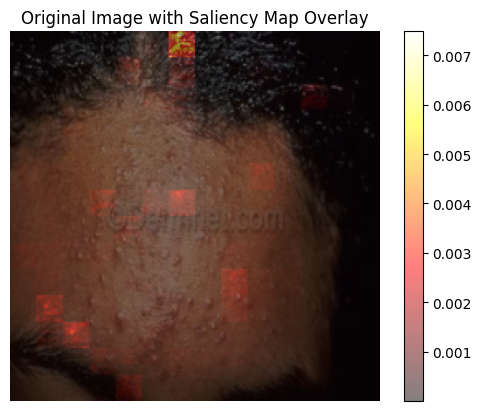

array([[[1.37975508e-06, 1.56316662e-06, 1.50595258e-06, ...,
         2.23273510e-05, 1.82193307e-05, 1.24097032e-05],
        [1.01849525e-06, 8.17460773e-07, 2.23498432e-06, ...,
         1.46604743e-05, 1.33076965e-05, 4.47450384e-06],
        [2.00736963e-06, 1.22178972e-06, 1.62592619e-06, ...,
         1.35391610e-05, 8.09359517e-06, 9.59528916e-06],
        ...,
        [7.39019606e-06, 1.39269323e-05, 1.07159231e-05, ...,
         1.77691727e-05, 1.26716623e-05, 1.06881889e-05],
        [1.54002500e-05, 1.55818598e-05, 1.47597411e-05, ...,
         1.76192898e-05, 1.11706258e-05, 1.21240701e-05],
        [2.04447315e-05, 2.64387345e-05, 2.00910163e-05, ...,
         1.09365665e-05, 1.33150888e-05, 1.40071579e-05]]], dtype=float32)

In [ ]:
generate_and_plot_saliency("/content/acne_acne-pustular-47.jpg", model)

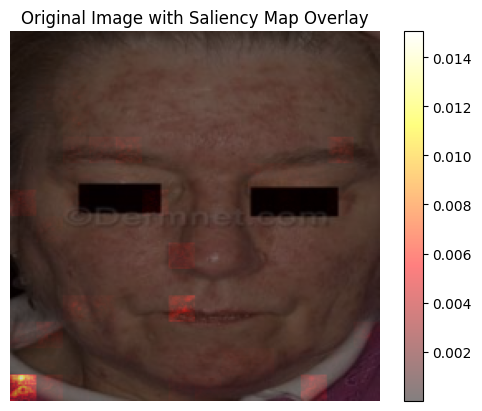

array([[[3.3490593e-05, 1.6684913e-05, 1.4183494e-05, ...,
         2.3918677e-05, 1.7799006e-05, 2.6158608e-05],
        [4.1447722e-05, 2.0729123e-05, 2.1856629e-05, ...,
         2.7652626e-05, 1.7984947e-05, 1.9870517e-05],
        [5.0142698e-05, 3.0100018e-05, 2.7697408e-05, ...,
         2.9823463e-05, 1.6006819e-05, 2.3678234e-05],
        ...,
        [4.6750461e-03, 5.0651976e-03, 6.6097132e-03, ...,
         1.0330802e-05, 1.1787941e-05, 1.6759994e-05],
        [2.6296137e-03, 2.9597718e-03, 3.6525989e-03, ...,
         9.0992007e-06, 9.8616601e-06, 1.4232589e-05],
        [4.8095137e-03, 4.8291758e-03, 4.1574826e-03, ...,
         9.5220093e-06, 6.8608306e-06, 1.0074550e-05]]], dtype=float32)

In [ ]:
generate_and_plot_saliency("/content/rosacea_07rosaceaTreated091806OK.jpg", model)

In [ ]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

In [ ]:
import torch.nn.functional as F
def predict(model, tensor_image):
    model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor_image = tensor_image.to(device)
    model.to(device)

    with torch.no_grad():
        outputs = model(tensor_image).logits
        # Apply softmax to convert logits to probabilities
        probabilities = F.softmax(outputs, dim=1)
    label_mapping = {0: 'acne', 1: 'redness', 2: 'bags', 3: 'rosacea', 4: 'actinic keratosis', 5: 'basal cell carcinoma', 6: 'eczemaa', 7: 'redness', 8: 'bags'}

    probabilities = probabilities[0].cpu().numpy()
    predicted_probabilities = {label_mapping[idx]: prob for idx, prob in enumerate(probabilities)}

    return predicted_probabilities

In [ ]:
# Batch tensor
tensor_image = preprocess_image("/content/acne_6_right_side.jpg")

predicted_probabilities = predict(model, tensor_image)
print("Predicted probabilities:")
for label, probability in predicted_probabilities.items():
    print(f"{label}: {probability:.4f}")

Predicted probabilities:
acne: 0.3529
redness: 0.0054
bags: 0.1069
rosacea: 0.2330
actinic keratosis: 0.0799
basal cell carcinoma: 0.2052
eczemaa: 0.0166
